# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


# Importing the necessary packages:

In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Helper functions for the advanced lane finding pipeline

In [15]:
# Camera Calibration Function

def Camera_Calibration(Checker_Board_Size, Read_image, Write_image):
    
    # Initailizing the object points
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
      
    # Using the path provided for reading the distorted image
    images = glob.glob(Read_image)
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        image = mpimg.imread(fname)
        gray_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        
        # Finding the Chessboard corners
        
        ret, corners = cv2.findChessboardCorners(gray_image,(9,6),None)

        # If found, append object points, image points to respective arrays
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            image = cv2.drawChessboardCorners(image, (9,6), corners, ret)
            
            # Storing the images with corners drawn
            cv2.imwrite(Write_image + 'Image_with_corners ' + str(idx+1) + '.jpg',image)
            
    return objpoints, imgpoints

# Image Undistort Function

def Undistort(image, mtx, dist):
            
    # Extracting the undistorted image from the distorted image
    Undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    
    return Undistorted_image

#  Absolute Sobel Thresholding

def Absolute_Sobel(Gray_image, Sobel_Kernel, Orient, thresh):
    
    # Finding the gradient in x or y direction
    if Orient == 'x':
        Sobel = cv2.Sobel(Gray_image, cv2.CV_64F,1,0,ksize = Sobel_Kernel)
    
    elif Orient == 'y':
        Sobel = cv2.Sobel(Gray_image, cv2.CV_64F,0,1,ksize = Sobel_Kernel)
    
    # Finding the absolute value of the gradient
    abs_Sobel = np.abs(Sobel)
    
    # Scaling to 8-bit and converting it to np.uint8
    scaled_Sobel = np.uint8((255*abs_Sobel)/np.max(abs_Sobel))
    
    # Creating a binary image 
    sbinary = np.zeros_like(scaled_Sobel)
    sbinary[(scaled_Sobel <= thresh[1]) & (scaled_Sobel >= thresh[0])] = 1
    
    return sbinary

# Magnitude Sobel Thresholding

def Magnitude_Sobel(Gray_image, Sobel_Kernel, mag_thresh):
    
    # Finding the gradient in x and y direction
    xSobel = cv2.Sobel(Gray_image, cv2.CV_64F,1,0,ksize = Sobel_Kernel)
    ySobel = cv2.Sobel(Gray_image, cv2.CV_64F,0,1,ksize = Sobel_Kernel)
    
    # Finding the magnitude value of the gradient
    Mag_Sobel = np.sqrt(xSobel**2 + ySobel**2)
    
    # Scaling to 8-bit and converting it to np.uint8
    scaled_Sobel = np.uint8((255*Mag_Sobel)/np.max(Mag_Sobel))
    
    # Creating a binary image 
    mbinary = np.zeros_like(scaled_Sobel)
    mbinary[(scaled_Sobel <= mag_thresh[1]) & (scaled_Sobel >= mag_thresh[0])] = 1
    
    return mbinary

# Color Thresholding

def Color_Threshold_HSV(image,v_thresh):
    
    # Convert the RGB image to HSV
    HSV_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    
    # Extracting the V-values from HSV image
    Value = HSV_image[:,:,2]
    
    # Creating the binary image
    vbinary = np.zeros_like(Value)
    vbinary[(Value <= v_thresh[1]) & (Value >= v_thresh[0])] = 1
    
    return vbinary

    
def Color_Threshold_HLS(image,s_thresh):
    
    # Convert the RGB image to HLS
    HLS_image = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    
    # Extracting the s-values from HLS image
    Saturation = HLS_image[:,:,2]
    
    # Creating the binary image
    sbinary = np.zeros_like(Saturation)
    sbinary[(Saturation <= s_thresh[1]) & (Saturation >= s_thresh[0])] = 1
    
    return sbinary

def Pers_Transform(Undist_image):
    
    # Defining the points of the rectangle in the normal camera view
    src = np.float32([[730,460],
                      [600,460],
                      [250,720],
                      [1180,720]])

    offset = 200
    # Defining the points of the rectangle in the Bird's eye view
    dst = np.float32([[Undist_image.shape[1]-offset,0],
                      [offset,0],
                      [offset,Undist_image.shape[0]],
                      [Undist_image.shape[1]-offset,Undist_image.shape[0]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(Undist_image, M, (Undist_image.shape[1], Undist_image.shape[0]), flags=cv2.INTER_LINEAR)
    
    return warped, dst, src, Minv

# Lane finding and measuring curvature using Slinding windows methods

def find_lane_lines(binary_warped):
    # Creating histogram of the pixels of the bottom half of the binary warped image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Creating an output image to visualize the result
    Output = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Hyper-parameters for the Slinding Window method
    nwindows = 10
    margin = 100
    minpix = 50
    
    # Measuring the each window height
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions for left and right line which needs to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identifying window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # Defining the boundary points of the current window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Drawing the windows on the output image for visualization
        cv2.rectangle(Output,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(Output,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        #Identifying the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) & (nonzerox>=win_xleft_low) & (nonzerox<win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) & (nonzerox>=win_xright_low) & (nonzerox<win_xright_high)).nonzero()[0]
        
        # Appending these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # Updating the center position for the next window if the minpix is exceeded
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extracting the left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fiting a second order polynomial through left and right line pixel positions
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

def Search_around_poly(left_fit, right_fit, binary_warped):
    
    margin = 100 # Width around the previous polynomial to search
    
    # Grabbing the activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Setting the area to search in the image
    
    left_lane_inds = ((nonzerox>(left_fit[2] + left_fit[1]*nonzeroy + left_fit[0] * np.square(nonzeroy)-margin)) & (nonzerox<(left_fit[2] + left_fit[1]*nonzeroy + left_fit[0] * np.square(nonzeroy)+margin)))
    right_lane_inds = ((nonzerox>(right_fit[2] + right_fit[1]*nonzeroy + right_fit[0] * np.square(nonzeroy)-margin)) & (nonzerox<(right_fit[2] + right_fit[1]*nonzeroy + right_fit[0] * np.square(nonzeroy)+margin)))
    
    # Extracting left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fiting a second order polynomial through left and right line pixel positions
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, left_lane_inds, right_lane_inds
    
# Mapping Lane Lines back onto the road along with the curvature and offset 

def Overlaying(left_fit, right_fit, left_lane_inds, right_lane_inds, Minv, Undist, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Extracting left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Generating y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    
    # Creating an output image to visualize the result
    Output = np.dstack((binary_warped, binary_warped, binary_warped))*255
    Output[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255,0,0]
    Output[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0,0,255]
    
    # Calculating the conversion factor to convert pixel value to real world unit i.e., in meters
    ym_per_pix = 30.0/720 
    xm_per_pix = 3.7/700 
    
    # Fiting a second order polynomial in the real world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculating the radius of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + np.square(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1]))**(3/2))/ np.absolute(2*left_fit_cr[0])  
    right_curverad = ((1 + np.square(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1]))**(3/2))/ np.absolute(2*right_fit_cr[0])
    Curvature = (left_curverad +right_curverad)/2
    
    # Calculating the direction and the magnitude of the offset    
    leftx_base = left_fit[0]*np.max(ploty)**2 + left_fit[1]*np.max(ploty) + left_fit[2]
    rightx_base = right_fit[0]*np.max(ploty)**2 + right_fit[1]*np.max(ploty) + right_fit[2]

    Offset = ((binary_warped.shape[1] - rightx_base - leftx_base)*xm_per_pix)/2
    
    if Offset > 0:
        Direction = 'Right'
    
    elif Offset <0:
        Direction = 'Left'
    
    else:
        Direction = 'Center'
    
    # Creating an image to show the selection window
    
    window_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    Lane_Lines = np.zeros_like(Undist)
    
    # Generating a polygon to illustrate the search window
    left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#    Warped_result = cv2.addWeighted(Output, 1, window_img, 0.25, 0)
    
    # Changing back the perspective to original
    Line_pts = np.hstack((left_line_pts,right_line_pts))
    cv2.fillPoly(Lane_Lines, np.int_([Line_pts]), (0,255,0))
    Unwarp = cv2.warpPerspective(Lane_Lines, Minv, (Undist.shape[1], Undist.shape[0]))
    Original_result = cv2.addWeighted(Undist, 1, Unwarp, 1, 0)
    
    # Overlaying the curvature and offset value and direction
    cv2.putText(Original_result, 'Radius of Curvature = ' + str(Curvature) + ' meters', (20,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(Original_result, 'The vehicle has a offset of ' + str(np.abs(Offset)) + ' meters towards ' + Direction + ' from the center' , (20,60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2, cv2.LINE_AA)
    
#    return Warped_result, Original_result, left_fitx, right_fitx
    return Output, Original_result, left_fitx, right_fitx

# Next cell is used to find Camera Matrix and Distortion Co-efficient: -

Text(0.5,1,u'Undistorted Image')

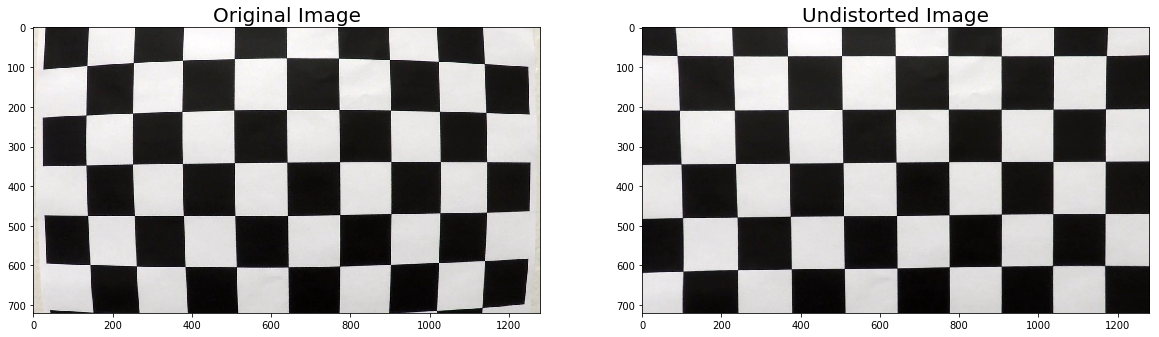

In [7]:
# Defining the reading and writing path to read and save the undistorted image
Read_image = 'camera_cal/calibration*.jpg'
Write_image = 'output_images/'

# Arrays to store object points and image points from all the images
global objpoints # 3d points in real world space
global imgpoints # 2d points in image plane
global mtx
global dist

mtx = 0
dist = 0
objpoints = []
imgpoints = []
# Defining the parametes required for Camera Calibration
Checker_Board_Size = [9,6]

#Passing the parameters through the helper functions to extract the Undistorted image
objpoints, imgpoints = Camera_Calibration(Checker_Board_Size, Read_image, Write_image)
Dist_image = mpimg.imread('camera_cal/calibration1.jpg')

# Finding the Camera Matrix and Distortion Co-efficient
ret, mtx, dist, revecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (Dist_image.shape[1],Dist_image.shape[0]), None, None)
Undist_image = Undistort(Dist_image, mtx, dist)     

# Plotting the Undistorted image against the distorted image

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(Dist_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(Undist_image)
ax2.set_title('Undistorted Image', fontsize=20)

# Pipeline for Advanced Lane Finding

In [8]:
def Pipeline(Dist_image):
    ### Undistort Image ###
    global Counter
    global left_fit
    global right_fit
    
    Undist_image = Undistort(Dist_image, mtx, dist)

    ## Thresholded Binary Image ###

    # Defining the parameters

    Sobel_Kernel = 5
    Orient = 'x'
    thresh = (10,80)
    mag_thresh = (50,200)
    v_thresh = (224, 255)
    s_thresh = (210, 255)
    
    Undist_Gray_image = cv2.cvtColor(Undist_image, cv2.COLOR_RGB2GRAY) 
    
    Absolute = Absolute_Sobel(Undist_Gray_image, Sobel_Kernel, Orient, thresh)
    Magnitude = Magnitude_Sobel(Undist_Gray_image, Sobel_Kernel, mag_thresh)
    Color_HSV = Color_Threshold_HSV(Undist_image,v_thresh)
    Color_HLS = Color_Threshold_HLS(Undist_image,s_thresh)

    Binary_image = np.zeros_like(Absolute)
    
    Binary_image[(((Absolute == 1) & (Magnitude == 1)) | (Color_HSV == 1) | (Color_HLS == 1))] = 1

    ### Perspective transform ###

    Binary_warped_image, dst, src, Minv = Pers_Transform(Binary_image)

    if Counter == 0:
        left_fit, right_fit,left_lane_inds, right_lane_inds = find_lane_lines(Binary_warped_image)
        Counter = Counter + 1
    elif Counter > 0:
        left_fit, right_fit,left_lane_inds, right_lane_inds = Search_around_poly(left_fit, right_fit, Binary_warped_image)


    Warped_Result, Final_Result,_,_ = Overlaying(left_fit, right_fit,left_lane_inds, right_lane_inds, Minv, Undist_image, Binary_warped_image)

    return Final_Result

In [19]:
Counter = 0
left_fit = None 
right_fit = None
output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
Video_clip = clip.fl_image(Pipeline)

%time Video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<03:44,  5.62it/s]


  0%|          | 2/1261 [00:00<03:46,  5.56it/s]


  0%|          | 3/1261 [00:00<03:46,  5.56it/s]


  0%|          | 4/1261 [00:00<03:46,  5.56it/s]


  0%|          | 5/1261 [00:00<03:39,  5.71it/s]


  0%|          | 6/1261 [00:01<03:37,  5.78it/s]


  1%|          | 7/1261 [00:01<03:39,  5.71it/s]


  1%|          | 8/1261 [00:01<03:35,  5.82it/s]


  1%|          | 9/1261 [00:01<03:36,  5.78it/s]


  1%|          | 10/1261 [00:01<03:34,  5.84it/s]


  1%|          | 11/1261 [00:01<03:37,  5.74it/s]


  1%|          | 12/1261 [00:02<03:35,  5.81it/s]


  1%|          | 13/1261 [00:02<03:37,  5.73it/s]


  1%|          | 14/1261 [00:02<03:35,  5.79it/s]


  1%|          | 15/1261 [00:02<03:40,  5.65it/s]


  1%|▏         | 16/1261 [00:02<03:37,  5.74it/s]


  1%|▏         | 17/1261 [00:02<03:39,  5.67it/s]


  1%|▏         | 18/1261 [00:03<03:36,  5.75it/s]


  2%|▏         | 19/1261 [0

 11%|█         | 134/1261 [00:31<04:51,  3.86it/s]


 11%|█         | 135/1261 [00:31<04:55,  3.81it/s]


 11%|█         | 136/1261 [00:31<04:41,  4.00it/s]


 11%|█         | 137/1261 [00:31<04:48,  3.90it/s]


 11%|█         | 138/1261 [00:32<04:35,  4.07it/s]


 11%|█         | 139/1261 [00:32<04:43,  3.96it/s]


 11%|█         | 140/1261 [00:32<04:33,  4.10it/s]


 11%|█         | 141/1261 [00:32<04:38,  4.02it/s]


 11%|█▏        | 142/1261 [00:33<04:36,  4.04it/s]


 11%|█▏        | 143/1261 [00:33<04:39,  4.00it/s]


 11%|█▏        | 144/1261 [00:33<04:37,  4.03it/s]


 11%|█▏        | 145/1261 [00:33<04:42,  3.95it/s]


 12%|█▏        | 146/1261 [00:34<04:38,  4.00it/s]


 12%|█▏        | 147/1261 [00:34<04:42,  3.95it/s]


 12%|█▏        | 148/1261 [00:34<04:40,  3.97it/s]


 12%|█▏        | 149/1261 [00:34<04:45,  3.90it/s]


 12%|█▏        | 150/1261 [00:35<04:45,  3.89it/s]


 12%|█▏        | 151/1261 [00:35<04:38,  3.98it/s]


 12%|█▏        | 152/1261 [00:35<04:37,  4.00i

 32%|███▏      | 398/1261 [01:38<03:38,  3.95it/s]


 32%|███▏      | 399/1261 [01:38<03:33,  4.03it/s]


 32%|███▏      | 400/1261 [01:38<03:37,  3.96it/s]


 32%|███▏      | 401/1261 [01:38<03:35,  4.00it/s]


 32%|███▏      | 402/1261 [01:39<03:43,  3.84it/s]


 32%|███▏      | 403/1261 [01:39<03:38,  3.93it/s]


 32%|███▏      | 404/1261 [01:39<03:46,  3.78it/s]


 32%|███▏      | 405/1261 [01:39<03:41,  3.87it/s]


 32%|███▏      | 406/1261 [01:40<03:44,  3.81it/s]


 32%|███▏      | 407/1261 [01:40<03:37,  3.93it/s]


 32%|███▏      | 408/1261 [01:40<03:41,  3.85it/s]


 32%|███▏      | 409/1261 [01:40<03:38,  3.90it/s]


 33%|███▎      | 410/1261 [01:41<03:40,  3.87it/s]


 33%|███▎      | 411/1261 [01:41<03:34,  3.97it/s]


 33%|███▎      | 412/1261 [01:41<03:36,  3.91it/s]


 33%|███▎      | 413/1261 [01:41<03:33,  3.97it/s]


 33%|███▎      | 414/1261 [01:42<03:38,  3.88it/s]


 33%|███▎      | 415/1261 [01:42<03:32,  3.98it/s]


 33%|███▎      | 416/1261 [01:42<03:37,  3.88i

 52%|█████▏    | 662/1261 [02:47<02:59,  3.33it/s]


 53%|█████▎    | 663/1261 [02:47<02:55,  3.40it/s]


 53%|█████▎    | 664/1261 [02:47<02:49,  3.52it/s]


 53%|█████▎    | 665/1261 [02:47<02:50,  3.49it/s]


 53%|█████▎    | 666/1261 [02:48<02:48,  3.53it/s]


 53%|█████▎    | 667/1261 [02:48<02:42,  3.65it/s]


 53%|█████▎    | 668/1261 [02:48<02:40,  3.69it/s]


 53%|█████▎    | 669/1261 [02:49<02:44,  3.61it/s]


 53%|█████▎    | 670/1261 [02:49<02:40,  3.68it/s]


 53%|█████▎    | 671/1261 [02:49<02:41,  3.64it/s]


 53%|█████▎    | 672/1261 [02:49<02:38,  3.72it/s]


 53%|█████▎    | 673/1261 [02:50<03:05,  3.18it/s]


 53%|█████▎    | 674/1261 [02:50<02:51,  3.41it/s]


 54%|█████▎    | 675/1261 [02:50<02:52,  3.40it/s]


 54%|█████▎    | 676/1261 [02:51<02:40,  3.64it/s]


 54%|█████▎    | 677/1261 [02:51<02:45,  3.54it/s]


 54%|█████▍    | 678/1261 [02:51<02:37,  3.70it/s]


 54%|█████▍    | 679/1261 [02:51<02:42,  3.58it/s]


 54%|█████▍    | 680/1261 [02:52<02:34,  3.76i

 73%|███████▎  | 926/1261 [03:54<01:24,  3.94it/s]


 74%|███████▎  | 927/1261 [03:54<01:23,  4.01it/s]


 74%|███████▎  | 928/1261 [03:54<01:24,  3.94it/s]


 74%|███████▎  | 929/1261 [03:54<01:22,  4.00it/s]


 74%|███████▍  | 930/1261 [03:55<01:24,  3.90it/s]


 74%|███████▍  | 931/1261 [03:55<01:22,  4.00it/s]


 74%|███████▍  | 932/1261 [03:55<01:23,  3.93it/s]


 74%|███████▍  | 933/1261 [03:55<01:21,  4.02it/s]


 74%|███████▍  | 934/1261 [03:56<01:22,  3.95it/s]


 74%|███████▍  | 935/1261 [03:56<01:20,  4.03it/s]


 74%|███████▍  | 936/1261 [03:56<01:22,  3.95it/s]


 74%|███████▍  | 937/1261 [03:56<01:19,  4.05it/s]


 74%|███████▍  | 938/1261 [03:57<01:21,  3.95it/s]


 74%|███████▍  | 939/1261 [03:57<01:19,  4.03it/s]


 75%|███████▍  | 940/1261 [03:57<01:21,  3.94it/s]


 75%|███████▍  | 941/1261 [03:57<01:19,  4.00it/s]


 75%|███████▍  | 942/1261 [03:58<01:21,  3.90it/s]


 75%|███████▍  | 943/1261 [03:58<01:19,  3.98it/s]


 75%|███████▍  | 944/1261 [03:58<01:21,  3.88i

 94%|█████████▍| 1187/1261 [05:05<00:20,  3.69it/s]


 94%|█████████▍| 1188/1261 [05:05<00:19,  3.81it/s]


 94%|█████████▍| 1189/1261 [05:06<00:19,  3.70it/s]


 94%|█████████▍| 1190/1261 [05:06<00:18,  3.85it/s]


 94%|█████████▍| 1191/1261 [05:06<00:18,  3.71it/s]


 95%|█████████▍| 1192/1261 [05:06<00:18,  3.82it/s]


 95%|█████████▍| 1193/1261 [05:07<00:18,  3.72it/s]


 95%|█████████▍| 1194/1261 [05:07<00:17,  3.86it/s]


 95%|█████████▍| 1195/1261 [05:07<00:17,  3.75it/s]


 95%|█████████▍| 1196/1261 [05:07<00:16,  3.85it/s]


 95%|█████████▍| 1197/1261 [05:08<00:16,  3.80it/s]


 95%|█████████▌| 1198/1261 [05:08<00:16,  3.71it/s]


 95%|█████████▌| 1199/1261 [05:08<00:16,  3.80it/s]


 95%|█████████▌| 1200/1261 [05:09<00:16,  3.66it/s]


 95%|█████████▌| 1201/1261 [05:09<00:15,  3.80it/s]


 95%|█████████▌| 1202/1261 [05:09<00:15,  3.70it/s]


 95%|█████████▌| 1203/1261 [05:09<00:15,  3.84it/s]


 95%|█████████▌| 1204/1261 [05:10<00:15,  3.72it/s]


 96%|█████████▌| 1205/1261 [

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 54s, sys: 26 s, total: 3min 20s
Wall time: 5min 28s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

Text(0.5,1,u'Warped Binary Lane Lines Image')

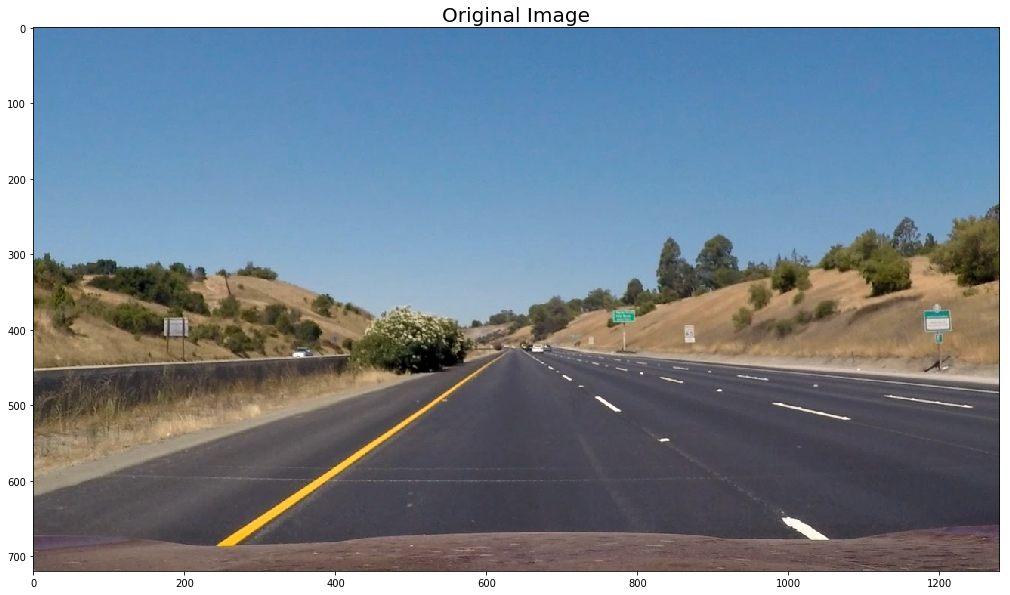

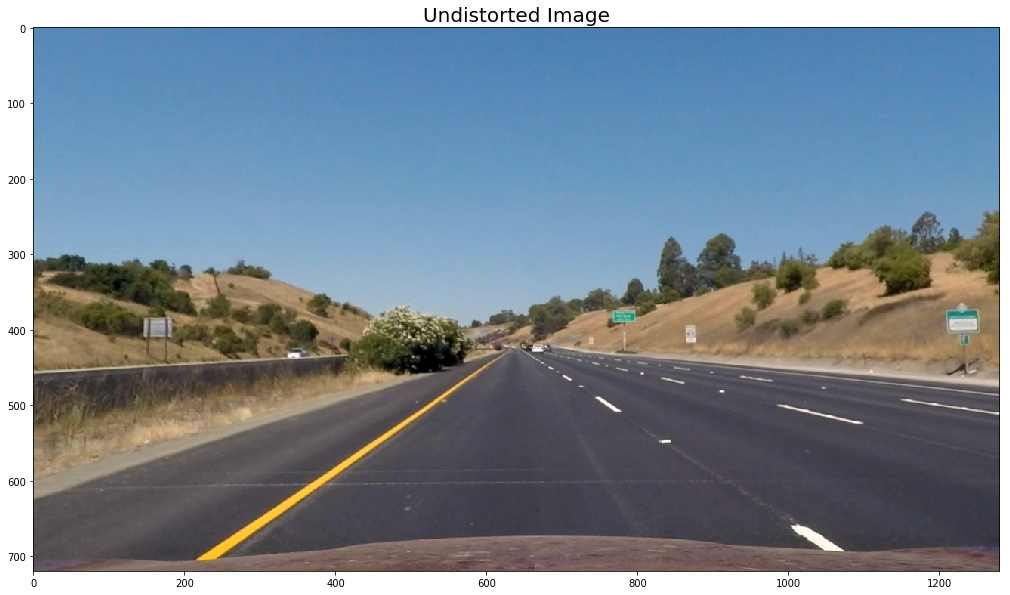

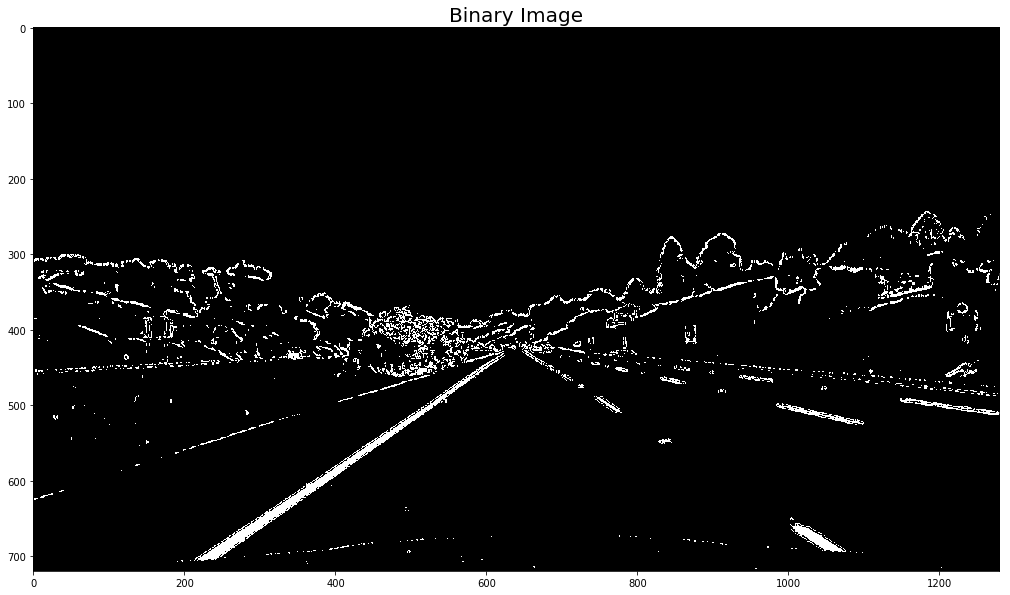

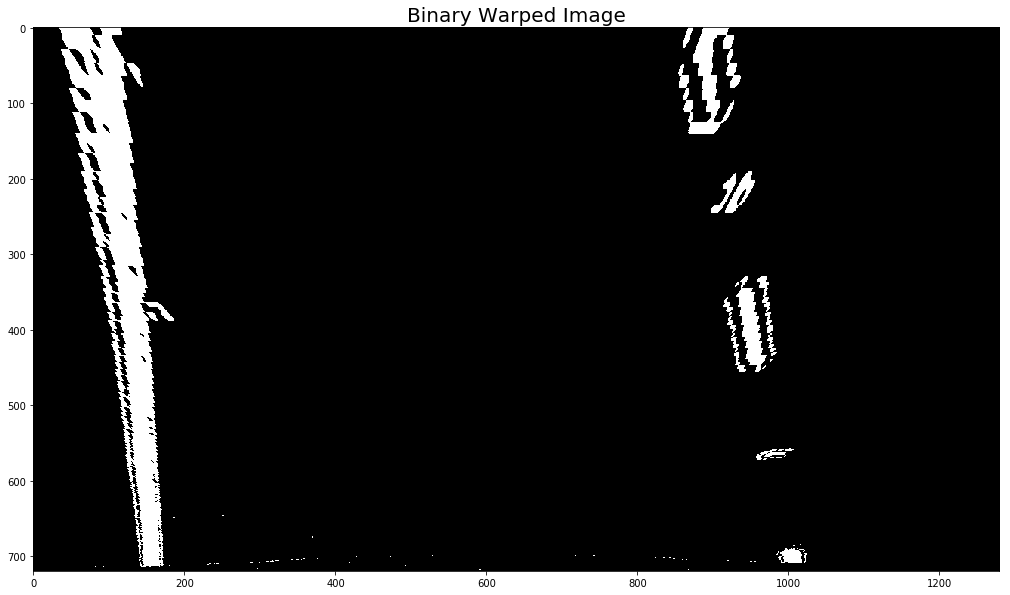

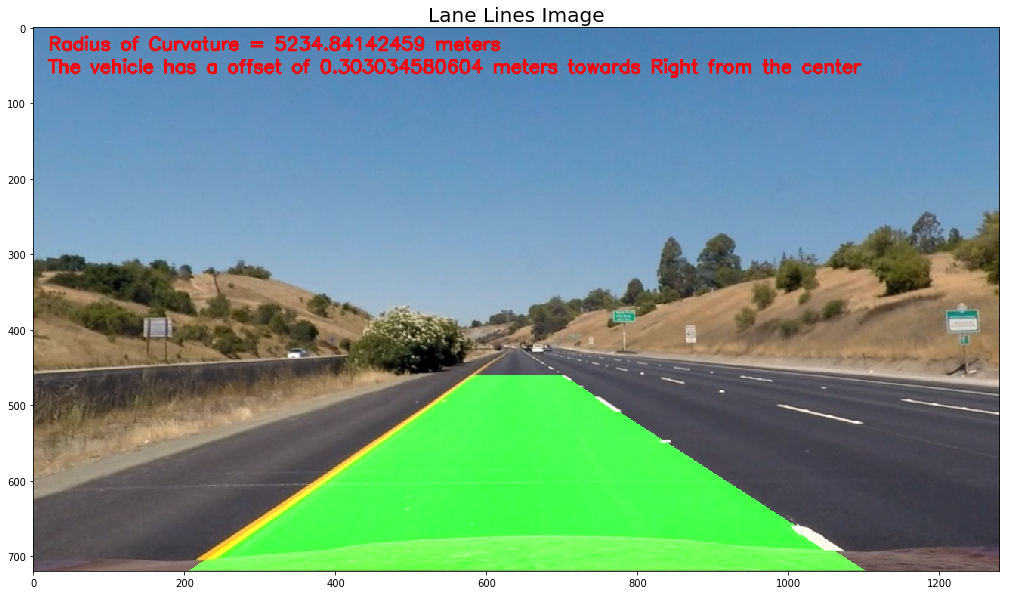

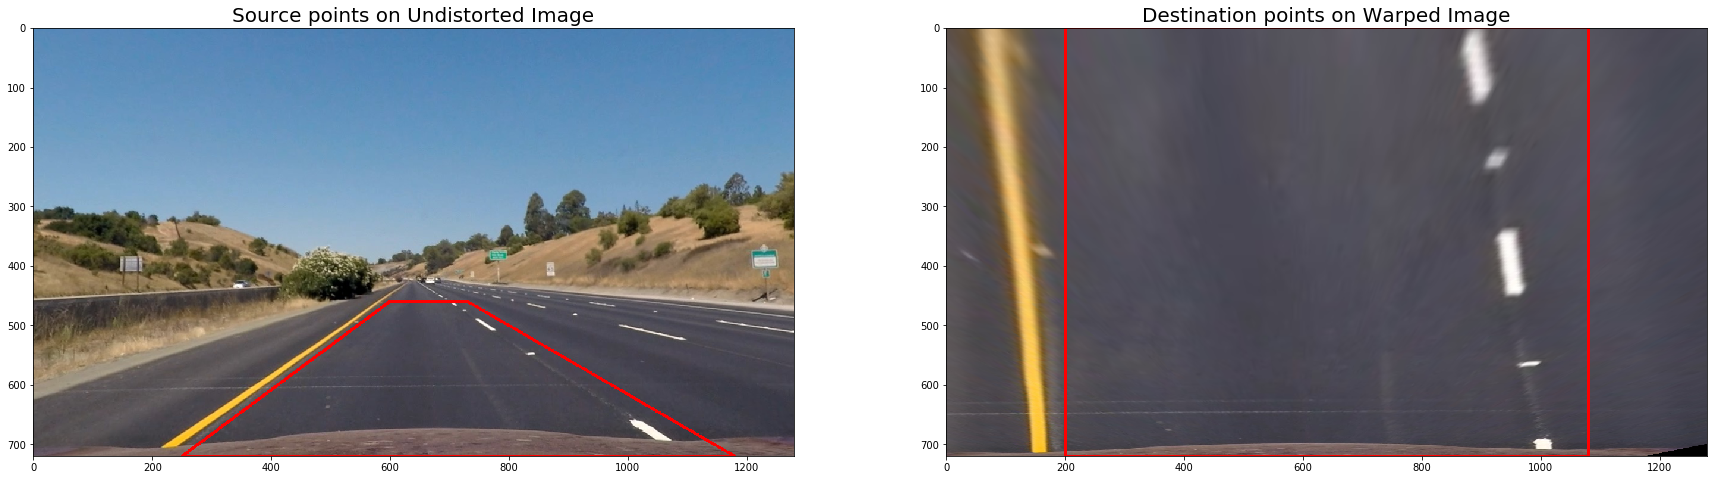

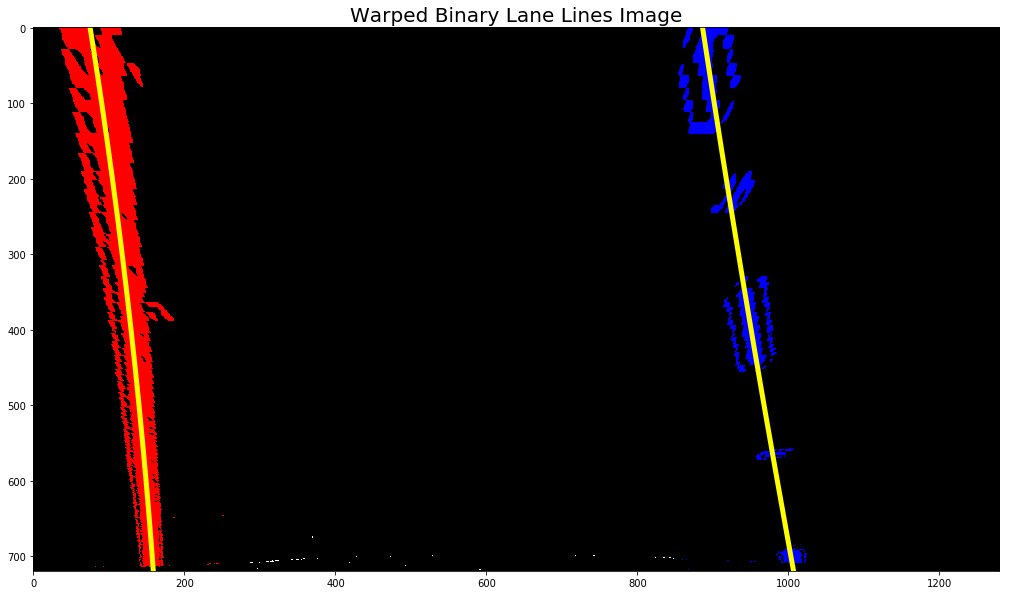

In [16]:
# Plotting the necessary images
Dist_image = mpimg.imread('test_images/straight_lines1.jpg')
f, ax = plt.subplots(1, 1, figsize=(20,10))
ax.imshow(Dist_image)
R,G,B = cv2.split(Dist_image)
Dist_image_save = cv2.merge((B,G,R))
cv2.imwrite('output_images/Original_Image.jpg',Dist_image_save)
ax.set_title('Original Image', fontsize=20)
Undist_image = Undistort(Dist_image, mtx, dist)
f, ax = plt.subplots(1, 1, figsize=(20,10))
ax.imshow(Undist_image)
R,G,B = cv2.split(Undist_image)
Undist_image_save = cv2.merge((B,G,R))
cv2.imwrite('output_images/Undistorted_Image.jpg',Undist_image_save)
ax.set_title('Undistorted Image', fontsize=20)

Sobel_Kernel = 5
Orient = 'x'
thresh = (10,80)
mag_thresh = (50,200)
v_thresh = (224, 255)
s_thresh = (210, 255)

Undist_Gray_image = cv2.cvtColor(Undist_image, cv2.COLOR_RGB2GRAY) 
Absolute = Absolute_Sobel(Undist_Gray_image, Sobel_Kernel, Orient, thresh)
Magnitude = Magnitude_Sobel(Undist_Gray_image, Sobel_Kernel, mag_thresh)
Color_HSV = Color_Threshold_HSV(Undist_image,v_thresh)
Color_HLS = Color_Threshold_HLS(Undist_image,s_thresh)
Binary_image = np.zeros_like(Absolute)
Binary_image[(((Absolute == 1) & (Magnitude == 1)) | (Color_HSV == 1) | (Color_HLS == 1))] = 1
f, ax = plt.subplots(1, 1, figsize=(20,10))
ax.imshow(Binary_image,cmap = 'gray')
cv2.imwrite('output_images/Binary_Image.jpg',Binary_image*255)
ax.set_title('Binary Image', fontsize=20)

Binary_warped_image, dst, src, Minv = Pers_Transform(Binary_image)
f, ax = plt.subplots(1, 1, figsize=(20,10))
ax.imshow(Binary_warped_image,cmap = 'gray')
cv2.imwrite('output_images/Binary_Warped_Image.jpg',Binary_warped_image*255)
ax.set_title('Binary Warped Image', fontsize=20)

left_fit, right_fit,left_lane_inds, right_lane_inds = find_lane_lines(Binary_warped_image)
Output, Lane_lines, left_fitx, right_fitx = Overlaying(left_fit, right_fit,left_lane_inds, right_lane_inds, Minv, Undist_image, Binary_warped_image)

f, ax = plt.subplots(1, 1, figsize=(20,10))
ax.imshow(Lane_lines)
R,G,B = cv2.split(Lane_lines)
Lane_lines_save = cv2.merge((B,G,R))
cv2.imwrite('output_images/Lane_lines_Image.jpg',Lane_lines_save)
ax.set_title('Lane Lines Image', fontsize=20)

Warped_image, dst, src, Minv = Pers_Transform(Undist_image)

Src_pts = np.array(src,np.int32)
Src_pts = Src_pts.reshape((-1,1,2))
cv2.polylines(Undist_image,[Src_pts], True,(255,0,0),3)

dst_pts = np.array(dst,np.int32)
dst_pts = dst_pts.reshape((-1,1,2))
cv2.polylines(Warped_image,[dst_pts], True,(255,0,0),3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.imshow(Undist_image)
ax1.set_title('Source points on Undistorted Image', fontsize=20)
ax2.imshow(Warped_image, cmap = 'gray')
ax2.set_title('Destination points on Warped Image', fontsize=20)

ploty = np.linspace(0, Binary_warped_image.shape[0]-1, Binary_warped_image.shape[0])

f, ax = plt.subplots(1, 1, figsize=(20,10))
ax.imshow(Output)
ax.plot(left_fitx, ploty, color='yellow', linewidth = 5)
ax.plot(right_fitx, ploty, color='yellow', linewidth = 5)
cv2.imwrite('output_images/Lane_lines_warped.jpg',Output)
ax.set_title('Warped Binary Lane Lines Image', fontsize=20)